## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
len(df[(df['group']=='treatment') & (df['landing_page']=='old_page')]) + \
len(df[(df['group']=='control') & (df['landing_page']=='new_page')])

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df
# drop unconfident rows
treat_no = df[(df['group']=='treatment') & (df['landing_page']=='old_page')]
ctrl_no = df[(df['group']=='control') & (df['landing_page']=='new_page')]
no_lineup = pd.concat([treat_no, ctrl_no])

df2 = df2.drop(no_lineup.index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop(labels=1899)
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2.group == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2.group == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
#df2[df2['landing_page']=='new_page'].mean()

In [19]:
df2[df2['landing_page']=='new_page'].count()/df2.count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The difference between control and treatment group is 0.2%, which is very low to say by confidence that the old version has a better conversion.
In question four we see that almost half of customers are tested in the new page system, which is a good sign to test compare our treatment and control group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H0: p_{new} - p_{old} \leq 0$ <br>
$H1: p_{new} - p_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [20]:
p_new = df2[df2['landing_page']=='new_page']['converted'].mean()
p_new

0.11880806551510564

In [21]:
p_old = df2[df2['landing_page']=='old_page']['converted'].mean()
p_old

0.1203863045004612

In [22]:
p_diff = p_new-p_old
p_diff

-0.0015782389853555567

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p__new = df2['converted'].mean()
p__new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p__old = df2['converted'].mean()
p__old

0.11959708724499628

In [25]:
p_mean = np.mean([p_new, p_old])

c. What is $n_{new}$?

In [26]:
n_new = len(df2[df2.group == 'treatment'])
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = len(df2[df2.group == 'control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted.mean()-old_page_converted.mean()

-0.0013372723040846884

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

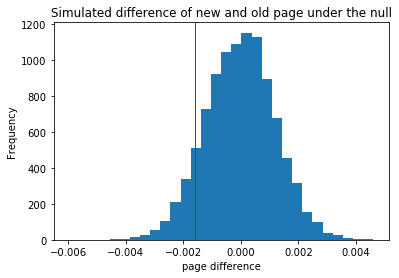

In [32]:
plt.hist(p_diffs, bins = 30)
plt.xlabel('page difference')
plt.ylabel('Frequency')
plt.axvline(x=(p_new-p_old), color='r', linewidth=1, label="Real difference")
plt.title('Simulated difference of new and old page under the null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
greater_proportion = len([i for i in p_diffs if i > p_diff]) / len(p_diffs)
print(f"Actual {p_diff}\nProportion {greater_proportion}")
print(f"proportion percentage {greater_proportion * 100}")

Actual -0.0015782389853555567
Proportion 0.9048
proportion percentage 90.48


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The calculated value is p-value. 
If the sample follow the null hypothesis we were expecting a value greater than 0.5, however we got almost 90 which mean our null hypothesis can't be rejected, so new pages don't have effects.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted'])])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted'])])
print(f"convert_old: {convert_old}\nconvert_new: {convert_new}\nn_old: {n_old}\nn_new: {n_new}")

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
# Find z-score and p-value
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old], alternative="larger")
print(f"z-score: {z_score} \np-value: {p_value}")

z-score: -1.3109241984234394 
p-value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Simply put, a z-score is the number of standard deviations from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is. [Source](http://www.statisticshowto.com/probability-and-statistics/z-score/)

The p-value is about 90% that shows we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept']= 1
df2['ab_page'] = 0

In [37]:
df2.set_value(index=df2[df2['group']=='treatment'].index, col='ab_page', value=1)
df2[['intercept', 'ab_page']] = df2[['intercept', 'ab_page']].astype(int)

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
logit = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])

result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Mar 2018   Pseudo R-squ.:               8.077e-06
Time:                        01:53:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value for ab_page is 0.190. actually by this p-value we find what we got earlier, 1 - 0.19 / 2 = 0.9
0.9 is the p-value we got in part 2. in part 2 we were concerned about which page had a higher conversion while in part 3, we are concerned if the condition has any effect at all, not the positive or negative change.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

When we are creating a regression model, we should only add features with huge impact and leave small impacts to the intercept. we could also take advantage of r-squared in order to figure out which feature should be added to the model.

In this example, we use only the group of the user (only one feature). however we could add more feature like time of the day or duration of time spending in the page to have better model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('countries.csv')
df_dummy = pd.get_dummies(data=countries_df, columns=['country'])
df_new = df_dummy.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country_CA,country_UK,country_US,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,
851104,0,0,1,2017-01-21 22:11:48.556739,control,old_page,0,1,0
804228,0,0,1,2017-01-12 08:01:45.159739,control,old_page,0,1,0
661590,0,0,1,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
853541,0,0,1,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
864975,0,0,1,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [42]:
logit_country = sm.Logit(df_new['converted'], 
                           df_new[['country_UK', 'country_US', 'intercept']])

result_country = logit_country.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [43]:
result_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 29 Mar 2018   Pseudo R-squ.:               1.521e-05
Time:                        02:04:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
==============================================================================
"""

It looks like that the country has a small effect on conversion rate but not too high to be statically significant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
df_m = df_new
#introducing a new interaction between country and page
df_m['UK_ab_page'] = df_m['country_UK'] * df_m['ab_page']

In [45]:
logit_countries = sm.Logit(df_new['converted'], df_new[['ab_page',
                                                      'country_UK',
                                                      'country_US',
                                                      'intercept',
                                                       'UK_ab_page']])
country_result = logit_countries.fit()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


In [46]:
country_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 29 Mar 2018   Pseudo R-squ.:               3.125e-05
Time:                        02:04:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1557
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0236      0.013     -1.785      0.074      -0.049       0.002
country_UK     0.0335      0.031      1.070      0.285      -0.028       0.095
country_US     0.0407      0.027      1.515      0.130      -0.012       0.093
intercept     -2.0257      0.027    -75.518      0.000      -2.078      -1.973
UK_ab_page     0.0344      0.026      1.306      0.192      -0.017       0.086
==============================================================================
"""

We have introduced a new interaction between UK country and ab_page. it has got a slightly better coef than country_uk but nothing statistically significant, so it has got a small effect on conversion rate.

<a id='conclusions'></a>
## Conclusions

As we have seen through the whole report, the conversion rates for new and old pages show that we can not reject the null hypothesis and the company should stay with the old design and even changes in countries does not affect any conversion rates.

This test had a good sufficient sample with a fair (50%) probability for each user to place in control or testament group, so I think there is no need for a longer or a rerun.